# Simple 2 Moving Average Model

In [1]:
import pandas as pd
from datetime import date, timedelta
from ma_cross_obj import MovingAverageTable

Downloading Data:

In [2]:
# YYYY-MM-DD
# for current day: str(date.today() - timedelta(1))
# for 60 days ago for smaller timeframes: str(date.today() - timedelta(59))
# for 730 days ago for smaller timeframes: str(date.today() - timedelta(729))

# Complete Table Creation

In [3]:
test = MovingAverageTable(ma1 = 50, ma2 = 250, ticker ="QQQ", start = "2020-05-08", end = str(date.today() - timedelta(1)), interval = "1d")
test.run_algo()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,Day Count,Open,High,Low,Close,50-day MA,250-day MA,Return %,Cumulative Return %,MA Model Return %,Cumulative MA Model Return %,Signal,Entry
Date,,,,,,,,,,,,,
2021-05-06,251,320.583,323.421,318.330,323.265,316.840,281.901,NaN,NaN,0.751,0.754,1,1.0
2021-05-07,252,326.053,328.277,323.440,325.888,316.992,282.321,0.808,0.811,0.808,1.571,1,0.0
2021-05-10,253,324.503,324.678,317.453,317.658,317.416,282.744,-2.558,-1.735,-2.558,-0.994,1,0.0
2021-05-11,254,311.748,318.018,311.085,317.219,317.650,283.152,-0.138,-1.870,-0.138,-1.131,1,0.0
2021-05-12,255,312.265,314.596,308.140,309.008,317.692,283.570,-2.622,-4.410,-2.622,-3.690,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,1251,467.130,477.200,462.430,475.470,477.260,484.214,-0.013,47.084,0.013,52.189,-1,0.0
2025-05-01,1252,483.410,487.180,480.740,481.680,475.998,484.428,1.298,49.005,-1.298,50.227,-1,0.0
2025-05-02,1253,486.540,490.910,484.830,488.830,474.857,484.679,1.473,51.217,-1.473,48.029,-1,0.0


In [4]:
test.sharpe()

 Buy/Hold Sharpe 0.422
 Model Sharpe 0.432


# MA Cross-Over Grid Visualization

from 2021-05-06-00:00 to 2025-05-06-00:00
count of buy signals: 1
count of sell signals: 2


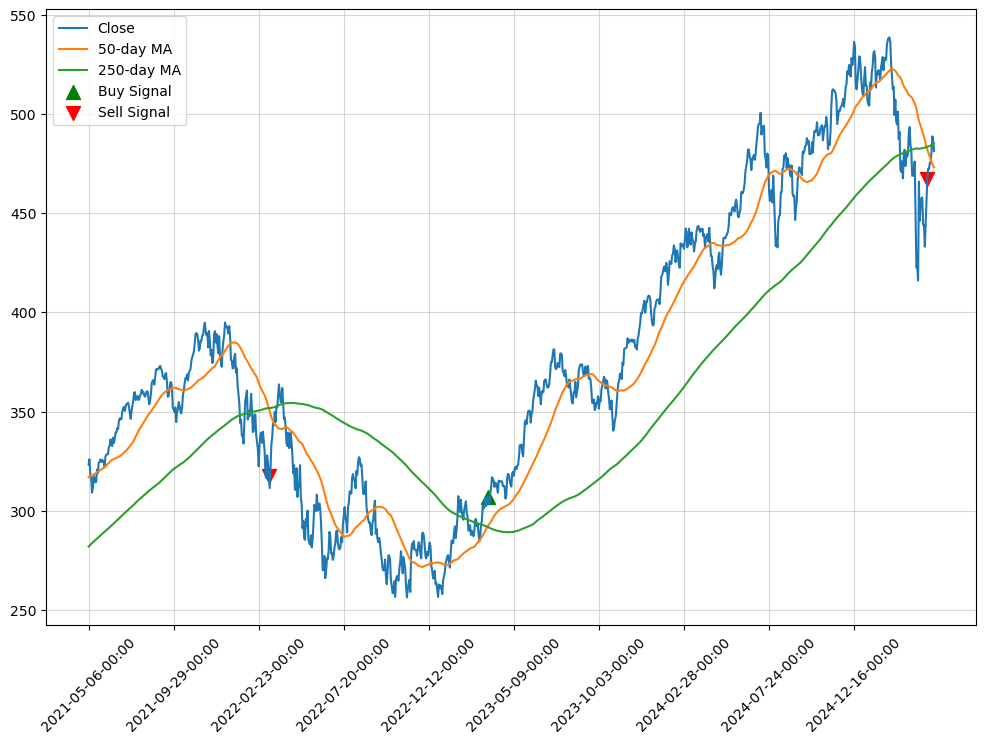

In [5]:
test.gen_visual()

# Buy/Hold to SMA Returns Comparison

QQQ Cumulative MA Model Return %: 50.31
QQQ Cumulative Return %: 48.92
 from 2021-05-06-00:00 to 2025-05-06-00:00


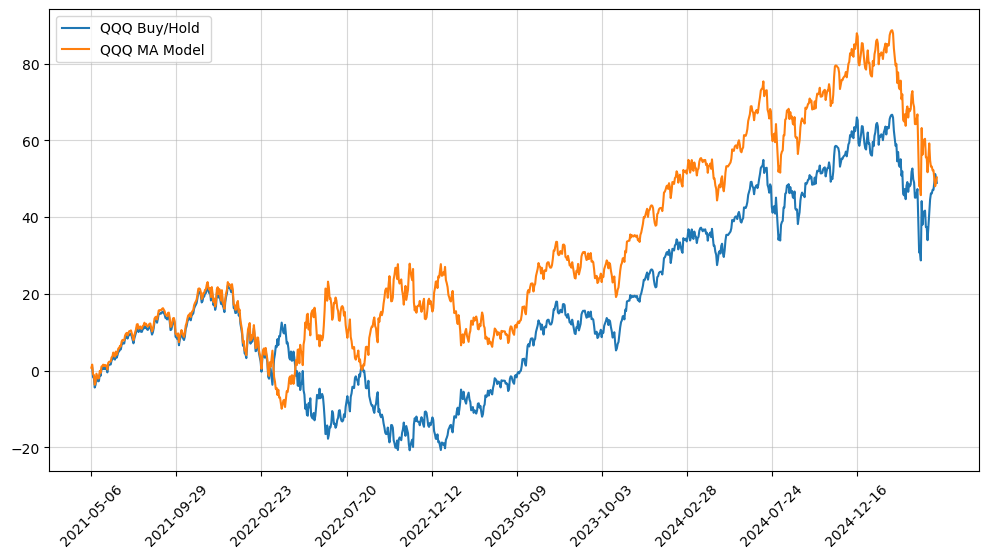

In [6]:
test.gen_comp()